# Low-Flow Index Indicators calculation
## It reads the dataset and calculates the mean, the standard deviation, max and minimun for the whole sample and the individual year. 

In [88]:
#imports
import pandas as pd
import numpy as np

In [89]:
# Import Data

LF_data = []

# LF Data
counter = 2001
while counter <= 2022:
    globals()[f'df_{str(counter)}'] = pd.read_csv("s3://ecb-hackathon-data-group08-x19s00/climate_data_full/low_flow_index/"
                                                      + "lfinx_NUTS3_MAX_" + str(counter) + ".csv")
    LF_data.append(globals()[f'df_{str(counter)}'])
    counter += 1

In [90]:
LF_data[17]

NUTS_ID   TIMESTAMP  \
0       AL011  2018-01-01   
1       AL013  2018-01-01   
2       AL014  2018-01-01   
3       AL015  2018-01-01   
4       AL021  2018-01-01   
...       ...         ...   
15343   UKN0B  2018-12-01   
15344   UKN0C  2018-12-01   
15345   UKN0D  2018-12-01   
15346   UKN0F  2018-12-01   
15347   UKN0G  2018-12-01   

        MONTHLY_MAX                                                   
0                                                    0.0              
1                                                    0.0              
2                                                    0.0              
3                                                    0.0              
4                                                    0.0              
...                                                  ...              
15343                                                0.0              
15344                                                0.0              
15345                                                0.0              
15346                                                0.0              
15347                                                0.0              

[15348 rows x 3 columns]

In [91]:
# combine all files in a single dataframe and include the "year" variable

counter = 0
LF_combined = pd.DataFrame(LF_data[0]) 
LF_combined['year'] = 2001
while counter < 21:
    counter += 1 
    extradata = pd.DataFrame(LF_data[counter]) 
    extradata['year'] = counter + 2001
    # LF_combined = LF_combined.append(extradata)
    LF_combined = pd.concat([LF_combined, extradata], ignore_index=True)

LF_combined = LF_combined.rename(columns = {' MONTHLY_MAX                                                 ' : 'MONTHLY_MAX'}) 

In [92]:
LF_combined.describe()
LF_combined.head()

NUTS_ID   TIMESTAMP  MONTHLY_MAX  year
0   AL011  2001-01-01          0.0  2001
1   AL013  2001-01-01          0.0  2001
2   AL014  2001-01-01          0.0  2001
3   AL015  2001-01-01          0.0  2001
4   AL021  2001-01-01          0.0  2001

In [93]:
column_names = LF_combined.columns
column_names

Index(['NUTS_ID', ' TIMESTAMP', 'MONTHLY_MAX', 'year'], dtype='object')

In [94]:
# get Long term average values of relevant metrics (LTA )
def getLTA(dataset,aggregationfunction,suffix):
    LTA = pd.pivot_table(dataset,
                         values=['MONTHLY_MAX'],
                         columns=['NUTS_ID'],
                         aggfunc=[aggregationfunction] )
    LTA = LTA.T
    LTA = LTA.droplevel(0)
    LTA = LTA.add_suffix(suffix)
    return LTA

LTA = getLTA(LF_combined,np.mean,'_LTA_mean')

extraLTA = getLTA(LF_combined,np.std,'_LTA_std')
LTA = pd.merge(LTA,extraLTA,on=['NUTS_ID'])

extraLTA = getLTA(LF_combined,np.max,'_LTA_max')
LTA = pd.merge(LTA,extraLTA,on=['NUTS_ID'])

LTA = LTA.add_prefix("LF_")

In [95]:
LTA

LF_MONTHLY_MAX_LTA_mean  LF_MONTHLY_MAX_LTA_std  \
NUTS_ID                                                    
AL011                   0.169595                0.297401   
AL013                   0.105208                0.260531   
AL014                   0.156148                0.292395   
AL015                   0.130390                0.282372   
AL021                   0.098894                0.236137   
...                          ...                     ...   
UKN0B                   0.073754                0.214874   
UKN0C                   0.043799                0.159379   
UKN0D                   0.070436                0.209784   
UKN0F                   0.041955                0.157468   
UKN0G                   0.045261                0.163161   

         LF_MONTHLY_MAX_LTA_max  
NUTS_ID                          
AL011                     0.998  
AL013                     0.969  
AL014                     0.998  
AL015                     0.987  
AL021                     0.956  
...                         ...  
UKN0B                     0.973  
UKN0C                     0.972  
UKN0D                     0.973  
UKN0F                     0.973  
UKN0G                     0.932  

[1279 rows x 3 columns]

In [96]:
# Compute aggregated basic variables (mean, std, max by year by region
LF_aggregated = LF_combined.groupby(['year','NUTS_ID']).agg({'MONTHLY_MAX':'mean'})
LF_aggregated = LF_aggregated.add_suffix('_Average')

additional_variable = LF_combined.groupby(['year','NUTS_ID']).agg({'MONTHLY_MAX':'std'})
additional_variable = additional_variable.add_suffix('_std')
LF_aggregated = pd.merge(LF_aggregated,additional_variable,on=['year','NUTS_ID'])

additional_variable = LF_combined.groupby(['year','NUTS_ID']).agg({'MONTHLY_MAX':'max'})
additional_variable = additional_variable.add_suffix('_max')
LF_aggregated = pd.merge(LF_aggregated,additional_variable,on=['year','NUTS_ID'])

LF_aggregated = LF_aggregated.add_prefix('LF_')

In [97]:
column_names = LF_aggregated.columns
column_names

Index(['LF_MONTHLY_MAX_Average', 'LF_MONTHLY_MAX_std', 'LF_MONTHLY_MAX_max'], dtype='object')

In [98]:
LF_aggregated = LF_aggregated.rename(columns = {'LF_MONTHLY_MAX_Average' : 'LF_average_a' ,\
                                                'LF_MONTHLY_MAX_std' : 'LF_std_a'  , \
                                                'LF_MONTHLY_MAX_max' : 'LF_max_a'}) 
LF_aggregated.to_csv('LF_aggregated.csv')

In [99]:
# SMA_aggregated.sort_values(by=['NUTS_CODE'])
LF_aggregated

LF_average_a  LF_std_a  LF_max_a
year NUTS_ID                                  
2001 AL011        0.248333  0.384583     0.889
     AL013        0.258667  0.396724     0.948
     AL014        0.000000  0.000000     0.000
     AL015        0.226000  0.381826     0.947
     AL021        0.242250  0.331956     0.895
...                    ...       ...       ...
2022 UKN0B        0.000000  0.000000     0.000
     UKN0C        0.000000  0.000000     0.000
     UKN0D        0.000000  0.000000     0.000
     UKN0F        0.000000  0.000000     0.000
     UKN0G        0.000000  0.000000     0.000

[28138 rows x 3 columns]

In [100]:
# combine aggregated and Long Term Average data

counter = 0
LTA_duplicated = LTA.copy()
LTA_duplicated['year'] = 2001
while counter < 17:
    counter += 1 
    extradata = LTA.copy()
    extradata['year'] = counter + 2001
    # SMA_combined = SMA_combined.append(extradata)
    LTA_duplicated = pd.concat([LTA_duplicated, extradata], ignore_index=False)

LF_aggregated_LTA = pd.merge(LF_aggregated,LTA_duplicated,on=['NUTS_ID','year'],how='left')


In [101]:
# compute SMA deviations from LTA for selected variables
LF_aggregated_LTA['LF_Average_Deviation_LTA'] = (
LF_aggregated_LTA['LF_average_a']- LF_aggregated_LTA['LF_MONTHLY_MAX_LTA_mean'] )

In [102]:
LF_aggregated_LTA.sort_values(by=['NUTS_ID','year'])

year  LF_average_a  LF_std_a  LF_max_a  LF_MONTHLY_MAX_LTA_mean  \
NUTS_ID                                                                    
AL011    2001      0.248333  0.384583     0.889                 0.169595   
AL011    2002      0.163000  0.320707     0.893                 0.169595   
AL011    2003      0.181000  0.315661     0.888                 0.169595   
AL011    2004      0.000000  0.000000     0.000                 0.169595   
AL011    2005      0.076667  0.190716     0.614                 0.169595   
...       ...           ...       ...       ...                      ...   
UKN0G    2018      0.000000  0.000000     0.000                 0.045261   
UKN0G    2019      0.000000  0.000000     0.000                      NaN   
UKN0G    2020      0.000000  0.000000     0.000                      NaN   
UKN0G    2021      0.000000  0.000000     0.000                      NaN   
UKN0G    2022      0.000000  0.000000     0.000                      NaN   

         LF_MONTHLY_MAX_LTA_std  LF_MONTHLY_MAX_LTA_max  \
NUTS_ID                                                   
AL011                  0.297401                   0.998   
AL011                  0.297401                   0.998   
AL011                  0.297401                   0.998   
AL011                  0.297401                   0.998   
AL011                  0.297401                   0.998   
...                         ...                     ...   
UKN0G                  0.163161                   0.932   
UKN0G                       NaN                     NaN   
UKN0G                       NaN                     NaN   
UKN0G                       NaN                     NaN   
UKN0G                       NaN                     NaN   

         LF_Average_Deviation_LTA  
NUTS_ID                            
AL011                    0.078739  
AL011                   -0.006595  
AL011                    0.011405  
AL011                   -0.169595  
AL011                   -0.092928  
...                           ...  
UKN0G                   -0.045261  
UKN0G                         NaN  
UKN0G                         NaN  
UKN0G                         NaN  
UKN0G                         NaN  

[28138 rows x 8 columns]

In [103]:
# output for MICHAL to combine with other datasets
column_names = LF_aggregated_LTA.columns
column_names

Index(['year', 'LF_average_a', 'LF_std_a', 'LF_max_a',
       'LF_MONTHLY_MAX_LTA_mean', 'LF_MONTHLY_MAX_LTA_std',
       'LF_MONTHLY_MAX_LTA_max', 'LF_Average_Deviation_LTA'],
      dtype='object')

In [104]:
LF_aggregated_LTA = LF_aggregated_LTA.rename(columns = {'LF_MONTHLY_MAX_Average' : 'LF_average' ,\
                                                'LF_MONTHLY_MAX_std' : 'LF_std'  , \
                                                'LF_MONTHLY_MAX_max' : 'LF_max',  \
                                                 'LF_MONTHLY_MAX_LTA_mean' : 'LF_LTA_mean' ,\
                                                'LF_MONTHLY_MAX_LTA_std' : 'LF_LTA_std'  , \
                                                'LF_MONTHLY_MAX_LTA_max' : 'LF_LTA_max' }) 

In [105]:
LF_aggregated_LTA.to_csv('LF_aggregated.csv')

In [106]:
LF_aggregated_LTA.describe()

year  LF_average_a      LF_std_a     LF_max_a   LF_LTA_mean  \
count  28138.000000  28138.000000  28138.000000  28138.00000  23022.000000   
mean    2011.500000      0.122853      0.166659      0.45938      0.122853   
std        6.344402      0.167507      0.151550      0.39014      0.069755   
min     2001.000000      0.000000      0.000000      0.00000      0.000000   
25%     2006.000000      0.000000      0.000000      0.00000      0.070182   
50%     2011.500000      0.057833      0.161123      0.50700      0.112019   
75%     2017.000000      0.175000      0.301806      0.85000      0.165830   
max     2022.000000      0.975583      0.513632      1.00000      0.467723   

         LF_LTA_std    LF_LTA_max  LF_Average_Deviation_LTA  
count  23022.000000  23022.000000              23022.000000  
mean       0.253342      0.947694                 -0.012943  
std        0.076083      0.157103                  0.143381  
min        0.000000      0.000000                 -0.467557  
25%        0.209023      0.964000                 -0.096557  
50%        0.259420      0.985000                 -0.044644  
75%        0.308557      0.997000                  0.029013  
max        0.411929      1.000000                  0.875265

In [107]:
# plot LF on maps
import geopandas as gpd 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

%matplotlib inline

def plotDfAsMap(df,columnname,title):
    #ax= df.plot(figsize=(10,10))
    ax=df.plot(cmap='RdBu',column=columnname)
    minx, miny, maxx, maxy = 20e5, 10e5, 80e5, 70e5
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.margins(0)
    ax.set_title(title)
    plt.show()

# https://matplotlib.org/stable/users/explain/colors/colormaps.html

In [108]:
#Read shapefiles
world_data = gpd.read_file(r's3://ecb-hackathon-data-group08-x19s00/economic_data/regional_boundaries/NUTS_RG_20M_2021_3035.shp') 
world_data = world_data[world_data.LEVL_CODE==3]

# try to combine with dataset

world_data.sort_values(by=['NUTS_ID'])
year = 2001
LF_aggregated_LTA_selection = LF_aggregated_LTA[LF_aggregated_LTA.year==year]
plot_data = pd.merge(world_data,LF_aggregated_LTA_selection,on=['NUTS_ID'],how='right')

In [109]:
plot_data

NUTS_ID  LEVL_CODE CNTR_CODE                 NAME_LATN  \
0      AL011          3        AL                     Dibër   
1      AL013          3        AL                     Kukës   
2      AL014          3        AL                     Lezhë   
3      AL015          3        AL                   Shkodër   
4      AL021          3        AL                   Elbasan   
...      ...        ...       ...                       ...   
1274   UKN0B          3        UK                Mid Ulster   
1275   UKN0C          3        UK  Causeway Coast and Glens   
1276   UKN0D          3        UK   Antrim and Newtownabbey   
1277   UKN0F          3        UK       Mid and East Antrim   
1278   UKN0G          3        UK       Fermanagh and Omagh   

                     NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  \
0                        Dibër         4.0          3           3  AL011   
1                        Kukës         4.0          3           3  AL013   
2                        Lezhë         4.0          3           1  AL014   
3                      Shkodër         4.0          2           1  AL015   
4                      Elbasan         4.0          3           2  AL021   
...                        ...         ...        ...         ...    ...   
1274                Mid Ulster         4.0          3           2  UKN0B   
1275  Causeway Coast and Glens         4.0          3           1  UKN0C   
1276   Antrim and Newtownabbey         4.0          2           1  UKN0D   
1277       Mid and East Antrim         4.0          2           1  UKN0F   
1278       Fermanagh and Omagh         4.0          3           2  UKN0G   

                                               geometry  year  LF_average_a  \
0     POLYGON ((5198279.444 2144087.068, 5196828.952...  2001      0.248333   
1     POLYGON ((5200419.920 2147880.021, 5198279.444...  2001      0.258667   
2     POLYGON ((5169746.714 2142724.545, 5160927.774...  2001      0.000000   
3     POLYGON ((5129579.170 2204098.752, 5131629.340...  2001      0.226000   
4     POLYGON ((5200756.984 2085264.659, 5211962.696...  2001      0.242250   
...                                                 ...   ...           ...   
1274  POLYGON ((3273289.494 3655395.879, 3271158.193...  2001      0.112583   
1275  POLYGON ((3309324.536 3662898.099, 3273289.494...  2001      0.045750   
1276  POLYGON ((3306910.942 3621319.406, 3303102.928...  2001      0.116167   
1277  POLYGON ((3306910.942 3621319.406, 3302970.939...  2001      0.040500   
1278  POLYGON ((3214939.132 3602580.729, 3213799.010...  2001      0.000000   

      LF_std_a  LF_max_a  LF_LTA_mean  LF_LTA_std  LF_LTA_max  \
0     0.384583     0.889     0.169595    0.297401       0.998   
1     0.396724     0.948     0.105208    0.260531       0.969   
2     0.000000     0.000     0.156148    0.292395       0.998   
3     0.381826     0.947     0.130390    0.282372       0.987   
4     0.331956     0.895     0.098894    0.236137       0.956   
...        ...       ...          ...         ...         ...   
1274  0.254835     0.865     0.073754    0.214874       0.973   
1275  0.106854     0.277     0.043799    0.159379       0.972   
1276  0.266641     0.909     0.070436    0.209784       0.973   
1277  0.094649     0.251     0.041955    0.157468       0.973   
1278  0.000000     0.000     0.045261    0.163161       0.932   

      LF_Average_Deviation_LTA  
0                     0.078739  
1                     0.153458  
2                    -0.156148  
3                     0.095610  
4                     0.143356  
...                        ...  
1274                  0.038830  
1275                  0.001951  
1276                  0.045731  
1277                 -0.001455  
1278                 -0.045261  

[1279 rows x 18 columns]

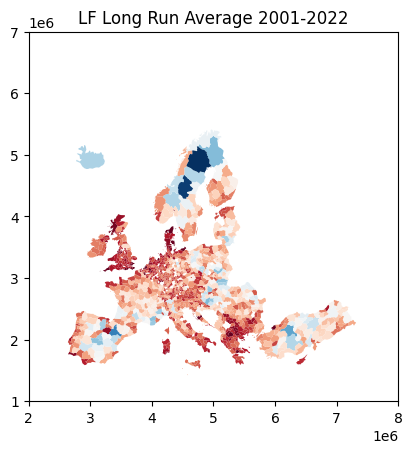

In [111]:
plotDfAsMap(plot_data,'LF_LTA_mean','LF Long Run Average 2001-2022')